In [3]:
from __future__ import division
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline
import random

We previously talked about using Gradient Descent in order to optimize complex functions for which we have no analytical expression. Let's take a look at a few more examples.

## Paraboloid

Let's use this simple paraboloid to explore gradient descent algorithms. Notice that the curvature of this surface is much stronger in the y-dimension than in the x-dimension. This will lead to some interesting properties.

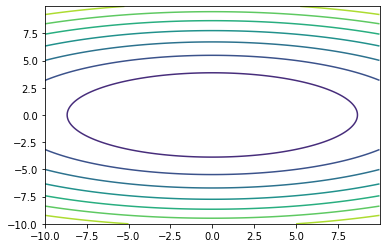

In [4]:
delta = 0.025
x = np.arange(-10.0, 10.0, delta)
y = np.arange(-10.0, 10.0, delta)
X, Y = np.meshgrid(x, y)
Z = X**2 / 125 +  Y**2 / 25
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)

In [5]:
def grad_f(vector):
    x, y = vector
    df_dx = (2/125)*x 
    df_dy = (2/25)*y
    return np.array([df_dx, df_dy])

In [6]:
def grad_descent(starting_point=None, iterations=10, learning_rate=12):
    if starting_point is None:
        point = np.random.uniform(-10, 10, size = 2)
    else:
        point = starting_point
    trajectory = [point]
    
    for i in range(iterations):
        grad = grad_f(point)
        point = point - learning_rate * grad
        trajectory.append(point)
    return np.array(trajectory)

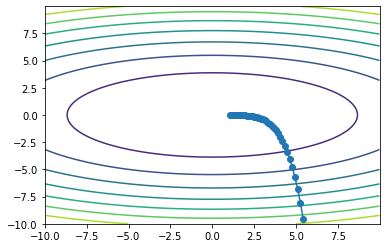

In [8]:
np.random.seed(10)
traj = grad_descent(iterations=50, learning_rate=2)

fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)
x= traj[:,0]
y= traj[:,1]
plt.plot(x,y,'-o')

## Exercise
 Take a look at what happens when the learning rate is low, such as around 1. What happens when the learning rate is much smaller than 1? What is the downside of making the learning rate too small?
 
 Take a look at what happens when the learning rate is higher, like 10 to 15. 
 

## Momentum

When the curvature of the loss fuction is much higher in one dimension than in the other(s), gradient descent has some drawbacks. The gradient is much stronger in one of the dimensions and this dominates where the next step goes. Unfortunately, we have a tendency to over-step in this direction and we have to then walk back down the hill in the next step. The oscillatory behavior is wasteful, and at the same time, we move only very very slowly in the other dimension. 

There are a family of methods that seek to overcome this problem by utilizing not just the instantaeous gradient information, but also some information about the past of the trajectory. Gradient Descent with Momentum is the simplest of these and the one which we will explore here. Yet other methods also include adaptive learning rate by considering the curvature in each dimension of the loss function: AdaGrad, RMSprop, and Adam.

In [16]:
def grad_descent_with_momentum(starting_point=None, iterations=10, alpha=.9, epsilon=10):
    if starting_point is not None:
        point = starting_point
    else:
        point = np.random.uniform(-10, 10, size = 2)
        
    trajectory = [point]
    v = np.zeros(point.size)
    
    for i in range(iterations):
        grad = grad_f(point)
        v = alpha * v + epsilon * grad
        point = point - v
        trajectory.append(point)
        
    return np.array(trajectory)

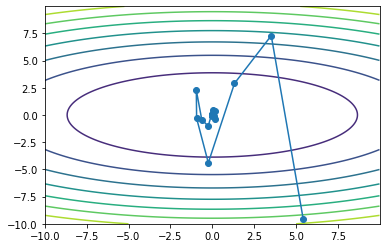

In [17]:
np.random.seed(10)
traj = grad_descent_with_momentum(iterations=50, epsilon=22, alpha=.5)

fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)
x= traj[:,0]
y= traj[:,1]
plt.plot(x,y,'-o')

## Exercise
(Make sure to set random seeds for better comparisons.)

Explore the Momentum algorithm with different values of epsilon. Try epsilson near 1 and near 10, see if the oscillatory before we saw before seems more dampened.

What effects do you notice of exploring different values of alpha, such as .5, .9, .99 and so on.

Make comparisons between gradient descent from the same starting poitn, with and without momentum. Make sure the "learning_rate" and "epsilon" are the same, respectively. How does alpha impact this comparison?


## Loss Functions
Instead of doing gradient descent on parameteric function like the paraboloid, we can do gradient descent on other complex functions we wish to minimize. In machine learning and statistics, we nearly always have some Loss function that we aim to minimize, so let's look at an example.

### OLS Regression

Recall our example model of simple OLS regression. Let's create a dataset like this and then fit our model using gradient descent.

Text(0.5, 0, 'X')

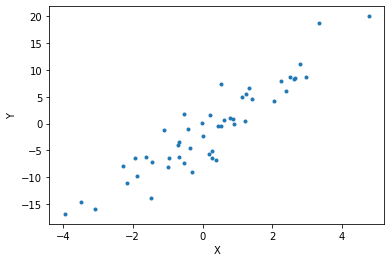

In [18]:
x = 2*np.random.randn(50)
y = 4*x -2 + 3*np.random.randn(len(x))
# what are the betas here?

plt.plot(x,y, '.')
plt.ylabel("Y")
plt.xlabel("X")

For a regression model, what loss function should we use? Write an implementation:

In [19]:
def loss(y, y_hat):
    # Root Mean Squared loss metric
    return np.sqrt(np.average((y-y_hat)**2))


Prediction
Write a function **yhat()** that takes in an x value and the coefficients of our OLS model, and returns the predicted value of y.

In [20]:
def yhat(x, coeffs):
    # returns model prediction for simple OLS regressor
    beta_0, beta_1 = coeffs
    return beta_0 + beta_1 * x

In [21]:
np.test.assert_equal(
    yhat(2, (1,1)),
    3
)

AttributeError: 'PytestTester' object has no attribute 'assert_equal'

To minimize a Loss function, we just need to find the values of the parameters of the OLS model that lead to the smallest value of the Loss. In this way, a Loss function is a bit different than the paraboloid function that we minimized previously.

A Loss function depends on two kinds of inputs: data and the predictions of an ML model. The predictions of the ML model are controlled by the parameters of that model. In minimizing a Loss, it is **only** the model parameters that we can adjust when fitting a model. We can consider the data to be *fixed*. 

In the case of our Loss in this example problem (RMSE), our OLS model only has two parameters: $\beta_0$ and $\beta_1$. Therefore, to *fit* this model to a dataset, we find the values of  $\beta_0$ and $\beta_1$ that minimize the RMSE. 

Even though this Loss function is composed of both data and model parameters, we can write down expression for its important partial derivatives (more on this next time):

$\frac{\partial L}{\partial \beta_0} = -2\frac{1}{N}\sum_i(y_i - \hat{y}_i)$

$\frac{\partial L}{\partial \beta_0} = -2\frac{1}{N}\sum_i(y_i - \hat{y}_i)x$

Implement our function **grad_f()** which returns the local gradient for any location in $(\beta_0, \beta_1)$ space. 

For this Loss function (unlike the paraboloid) we need to pass in extra information such as the data x and y. Note that the terms in the gradient depend on the predictions $\hat{y}$, the ground truth $y$, and the inputs $x$. 

In [22]:
def grad_f(beta_0, beta_1, x, y):
    """
    Computes local gradient vector for squared-error loss on OLS regression model cofficients
    """
    # your code here
    d_beta0 = -2 * np.sum(y-yhat(x, [beta_0, beta_1]))/len(y)
    d_beta1 = -2 * np.sum((y-yhat(x, [beta_0, beta_1]))*x)/len(y)
    return np.array([d_beta0, d_beta1])

We can now run our gradient loop as before, using our new **grad_f()** function to minimize the Loss and find the best $\beta_0, \beta_1$.

In [23]:
def grad_descent(x, y, starting_point=None, iterations=10, learning_rate=1e-1):
    """
    Estimate the coefficients of simple regression model using gradient descent.
    model: y = beta_0 + beta_1*X
    
    Args
        x (np.array) 
        y (np.array)
        starting_point (tuple2) initialization point for gradient descent
        iterations (int) number of iterations before stopping
        learning_rate (float) 
        
    
    Returns
        (np.array) trajectory through parameter space towards minimum
        (np.array) total loss metric throughout gradient descent iterations
    """
    # your code here
    if starting_point == None:
        beta0 = 10
        beta1 = 10
    else:
        beta0 = starting_point[0]
        beta1 = starting_point[1]
    trajs = [(beta0, beta1)]
    
    z = loss(y, yhat(x, (beta0, beta1)))
    losses = [z]
    for i in range(iterations):
        g = grad_f(beta0, beta1, x, y)
        trajs.append([beta0, beta1])
        beta0 = beta0 - learning_rate * g[0]
        beta1 = beta1 - learning_rate * g[1]
        tmp = loss(y, yhat(x, (beta0, beta1)))
        if tmp >z:
            break
        z = tmp
        losses.append(tmp)
    return np.array(trajs), np.array(losses)


In [24]:
traj, losses = grad_descent(x, y, iterations=20,learning_rate=1e-1)

Text(0.5, 0, 'Iteration')

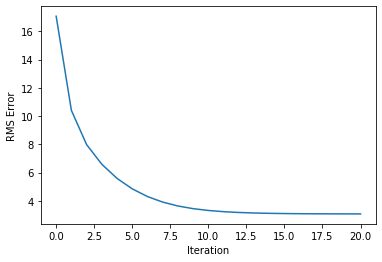

In [25]:
plt.plot(losses)
plt.ylabel("RMS Error")
plt.xlabel("Iteration")

Text(0, 0.5, 'beta_1')

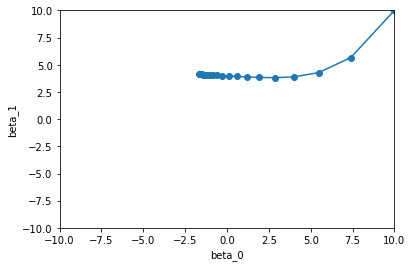

In [26]:
x= traj[:,0]
y= traj[:,1]
plt.plot(x,y,'-o')
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel("beta_0")
plt.ylabel("beta_1")